Objectif : calculer la p-valeur des données issues de la thèse de Ben. Il a un échantillon de médecins avant / après formation et observe le nombre de patient PrEP suivis. Est-ce que c'est significatif ?

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

# Données 

In [2]:
raw_data = """0	2	0	2	0	2	0	0	5	5	10	0	0	0	1	0	1	0	0	0	0	10	0	0	0	0	0	3	0	0	0	0	0	0	0	0	0	1	1,10526316	2,48007709
0	5	0	3	0	3	0	0	3	15	8	2	3	1	15	0	5	0	0	0	0	10	0	0	0	0	0	5	0	0	0	0	5	0	0	0	3	2	2,31578947	3,90498824"""

lines = raw_data.split('\n')

data_before = np.array(list(map(int, lines[0].split('\t')[:-2])))

data_after = np.array(list(map(int, lines[1].split('\t')[:-2])))

In [3]:
data_after

array([ 0,  5,  0,  3,  0,  3,  0,  0,  3, 15,  8,  2,  3,  1, 15,  0,  5,
        0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  5,  0,
        0,  0,  3,  2])

In [4]:
data_before

array([ 0,  2,  0,  2,  0,  2,  0,  0,  5,  5, 10,  0,  0,  0,  1,  0,  1,
        0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1])

In [5]:
np.mean(data_before)

1.105263157894737

In [6]:
np.mean(data_after)

2.3157894736842106

En moyenne, les médecins ont plus de patients PrEP après la formation :

In [7]:
 np.mean(data_after - data_before) 

1.2105263157894737

Quel est l'histogramme des deltas par médecin ?

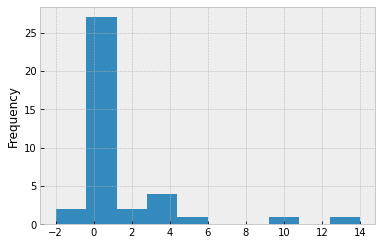

In [8]:
df = pd.DataFrame({'before': data_before, 'after': data_after})

df['delta'] = df.after - df.before 

df.delta.plot.hist()

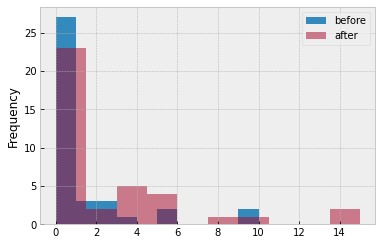

In [9]:
fig, ax = plt.subplots()
df.before.plot.hist(ax=ax)
df.after.plot.hist(ax=ax, alpha=0.5)
ax.legend()

# Test statistique 1 : pas d'hypothèse de normalité

![onlyonetest](https://lh4.googleusercontent.com/Bud31guq0w0FvylY57VMR0zHkYqxIpYAfOqgZietyvv1n2ToNEHwHKZWYix8pwct8kDKsZKiwvOWm6PIFEL3gBIQmbakQYHwVT02nn9_H8Fht_zaSBlrRNcqwZa950Vb5nt-5B84)

**H_0** : la distribution avant / après est la même. Donc on peut simuler des données sous l'hypothèse H_0 en mélangeant les valeurs obtenues.

In [10]:
class HypothesisTest():
    def __init__(self, data):
        self.data = data
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        "Returns p-value of actual data based on simulated data."
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        "Test statistic for the current test."
        raise UnimplementedMethodException()

    def RunModel(self):
        "Returns a simulated data sample."
        raise UnimplementedMethodException()

class BenTest(HypothesisTest):
    "Model for Ben's data."
    def __init__(self, data):
        super().__init__(data)
        
    def TestStatistic(self, simulated_data):
        "The statistic is the difference in means between `after` and `before` PrEP formation."
        before, after = simulated_data
        test_stat = np.mean(after) - np.mean(before)
        return test_stat

    def RunModel(self):
        "Returns a simulated data set of 38 observations under the H0 hypothesis."
        N = len(self.data[0])
        possible_values = np.concatenate(self.data)
        before = np.random.choice(possible_values, size=(N,))
        after = np.random.choice(possible_values, size=(N,))
        return (before, after)

data = (data_before, data_after)

bt = BenTest(data)

bt.actual

1.2105263157894737

In [11]:
bt.PValue(iters=30000)

0.05566666666666667

In [12]:
def plot_test_stat(test, title=""):
    "Plots the test statistic distribution and observed value."
    plt.hist(test.test_stats, bins=30, cumulative=False, density=True)
    ylim = plt.ylim()
    plt.vlines(test.actual, *ylim, label='observed test stat')
    plt.legend(loc='upper left')
    plt.xlabel('test statistic')
    plt.title(title)

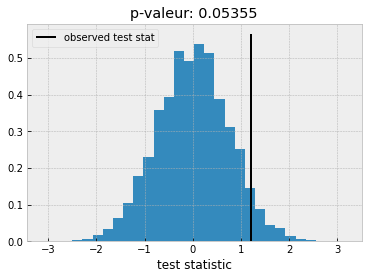

In [13]:
plot_test_stat(bt, f"p-valeur: {bt.PValue(iters=20000)}")

# Test 2 : hypothèse de normalité sur le delta

On travaille directement avec les delta des échantillons appariés. On fait l'hypothèse que ces delta suivent une loi normale. Dans l'hypothèse **H_0** ces lois normales ont la même moyenne (0) et la même variance (à calculer sur la distribution). 

In [14]:
class BenTestNormal(HypothesisTest):
    "Model for Ben's delta_data using a normal hypothesis. The delta_data here is directly differences between people."
    def __init__(self, delta_data):
        super().__init__(delta_data)
        self.std = np.std(delta_data)
        
    def TestStatistic(self, simulated_delta_data):
        "The statistic is the difference in means between `after` and `before` PrEP formation."
        test_stat = np.mean(simulated_delta_data)
        return test_stat

    def RunModel(self):
        "Returns a simulated delta_data set of 38 observations under the H0 hypothesis."
        N = len(self.data)
        delta_data = np.random.normal(loc=0, scale=self.std, size=(N,))
        return delta_data

In [15]:
btnormal = BenTestNormal(df.delta.values)

btnormal.actual

1.2105263157894737

In [16]:
btnormal.PValue(iters=30000)

0.0054666666666666665

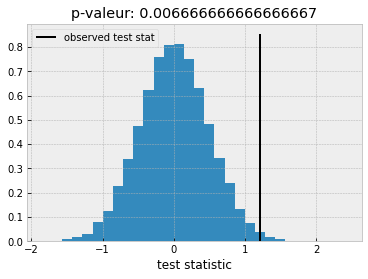

In [17]:
plot_test_stat(btnormal, f"p-valeur: {btnormal.PValue(iters=30000)}")

# Scipy 

In [22]:
import scipy.stats

In [24]:
scipy.stats.ttest_rel(data_after, data_before)

Ttest_relResult(statistic=2.5050766025946083, pvalue=0.01677377792344304)

In [20]:
m = np.mean(data_after - data_before)
s = np.std(data_after - data_before, ddof=1)
test_stat = m / (s / np.sqrt(data_after.size))
test_stat

2.505076602594608